# CS 4487 Deepfake Detection

### Group 38
* Nurdaulet TAUMERGENOV (56679550)
* Beket YERMEKOV (56679630)
* Alibi ZHENIS (57065469)


## Problem Statement

**Binary classification task**
* Techniques for convincing manipulations of digital face images
exist for decades via the use of visual effects
* Recent technologies in deep learning, especially “DeepFakes,”
have led to a dramatic increase in the realism of fake content
* While there are entertaining applications of DeepFakes, potential
weaponization of such techniques has raised great concerns
* DeepFake detection has become a pressing issue and a hot spot of
research

(from Dr. Kede Ma City University of Hong Kong
CS4487 Lecture 7.1)


## Dataset we used

Contains different types of manipulations to modify different face
semantic attributes (such as face ID, facial expression, and head
pose), with cropped and aligned face images of size
***317 × 317 × 3***

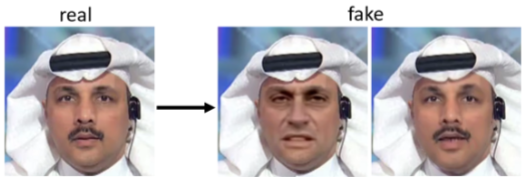

## Pretrained Models we used

We have used two deep learning models as backbone architectures for our project: **ResNet** and **EfficientNet**:
* These models were chosen due to their proven effectiveness in image classification tasks and their ability to capture intricate features and patterns in the data.
* They were originally trained on large-scale image classification tasks. By using these pre-trained weights we can benefit from the learned representations and feature extraction capabilities of these models.
* The lower layers of the pre-trained models capture general features that are useful for various computer vision tasks, while the higher layers learn more specific features relevant to the original classification task. <br>





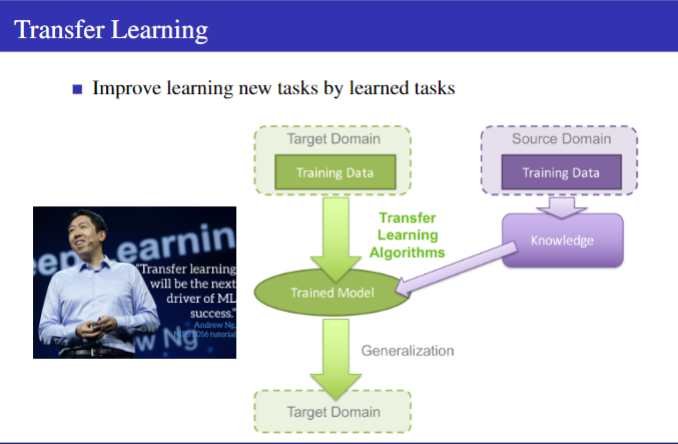

In our case, we have decided to use Linear Classifier on top layer
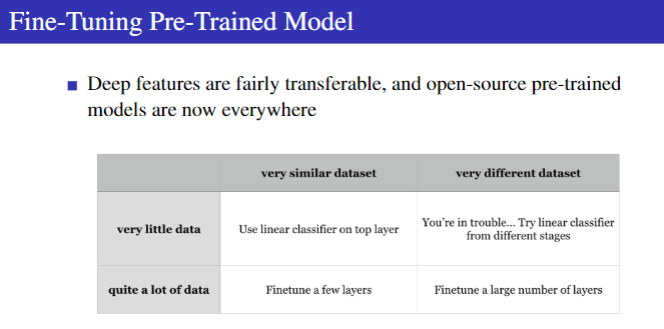

#### Model Architecture

* EfficientNetb6

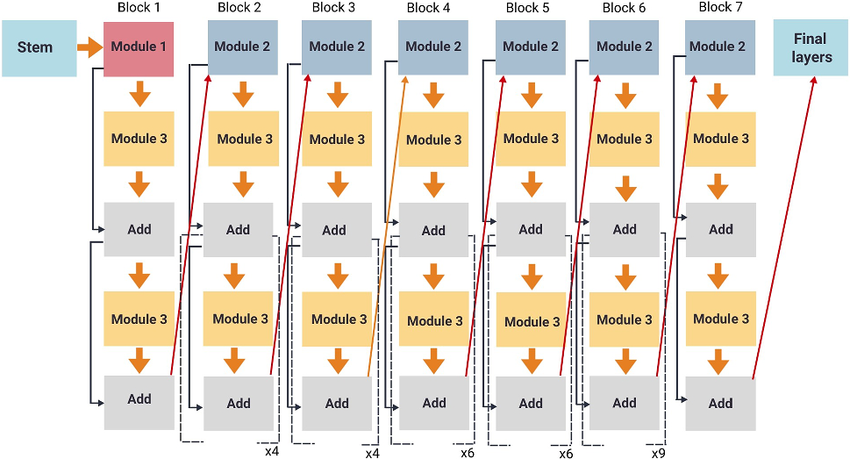

<hr>

* ResNet50

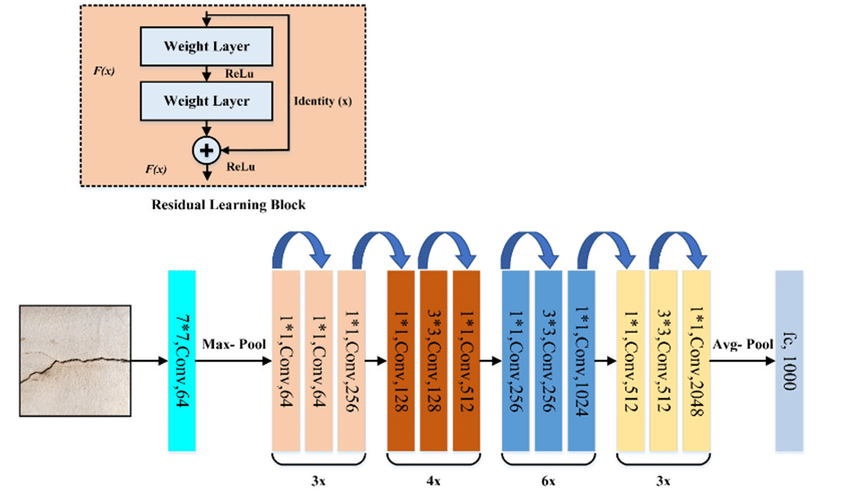

* For both models, we have added extra linear classifier layers on top (please refer to code below)

## Code Section

In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import glob

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [3]:
# %%capture _
# !unzip gdrive/My\ Drive/project_data.zip -d ./data

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


data_dir = '/kaggle/input/projectdata'
save_path = '/kaggle/working/'

In [5]:
# Data transform

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': v2.Compose([
        v2.RandomResizedCrop(224),
        v2.RandomHorizontalFlip(),
        v2.ToTensor(),
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': v2.Compose([
        v2.Resize(256),
        v2.CenterCrop(224),
        v2.ToTensor(),
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


### We used our own CustomDataset class to load the data from different folders

In [6]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform

        self.filepaths = glob.glob(os.path.join(data_dir, '**/*.jpg'), recursive=True)
        self.classes = ['real', 'fake']

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, index):
        filepath = self.filepaths[index]

        # Extract the class name from the filepath
        class_name = self.classes[1] if "Fake" in os.path.dirname(os.path.relpath(filepath, data_dir)) else \
        self.classes[0]

        # Map the class name to 'real' or 'fake'
        class_label = self.classes.index(class_name)

        # Load and transform the image
        image = Image.open(filepath)

        if self.transform is not None:
            image = self.transform(image)

        return image, class_label

In [7]:
data = {}
data["train"] = CustomDataset(os.path.join(data_dir, "train"), transform = data_transforms["train"])
data["val"] = CustomDataset(os.path.join(data_dir, "val"), transform = data_transforms["val"])

### For now, we only take 1% of the data (15 batches) to overfit and experiment with the models and hyperparameters

In [ ]:
small_data = {}

mask = list(range(1, len(data["train"]), 100))
small_data["train"] = torch.utils.data.Subset(data["train"], mask)

mask = list(range(1, len(data["val"]), 100))
small_data["val"] = torch.utils.data.Subset(data["val"], mask)

In [ ]:
dataloaders_small = {x: torch.utils.data.DataLoader(small_data[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

In [ ]:
dataset_sizes = {x: len(small_data[x]) for x in ["train", "val"]}
dataset_sizes

In [8]:
class_names = ['real', 'fake']

In [17]:

def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=25, verbose=True):
    since = time.time()

    accuracies = {'train' : [], 'val' : []}
    losses = {'train' : [], 'val' : []}
    
    model.to(device)
    
    tempdir = "/kaggle/working/"

    # Create a temporary directory to save training checkpoints
    best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

    torch.save(model.state_dict(), best_model_params_path)
    best_acc = 0.0

    for epoch in range(num_epochs):
        if verbose:
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            accuracies[phase].append(epoch_acc)
            losses[phase].append(epoch_loss)

            if verbose:
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_params_path)
        if verbose:
            print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(torch.load(best_model_params_path))
    return model, accuracies, losses

In [10]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def plot_accuracies(accuracies, title):
  train_accuracies = accuracies['train']
  val_accuracies = accuracies['val']
  # Plotting accuracy
  plt.figure()
  plt.plot(train_accuracies, label='Train Accuracy')
  plt.plot(val_accuracies, label='Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title(title)
  plt.legend()
  plt.show()

def plot_losses(losses, title):
  train_losses = losses['train']
  val_losses = losses['val']
  # Plotting accuracy
  plt.figure()
  plt.plot(moving_average(train_losses, 5), label='Train Loss')
  plt.plot(moving_average(val_losses, 5), label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title(title)
  plt.legend()
  plt.show()

In [11]:
def test(model, data_path):
    # Data transform

    # Data augmentation and normalization for training
    # Just normalization for validation
    data_transform = v2.Compose([
        v2.Resize(256),
        v2.CenterCrop(224),
        v2.ToTensor(),
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    test_data = CustomDataset(data_path, transform = data_transform)
    dataset_size = len(test_data)
    print("Dataset size: ", dataset_size)

    test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=32,
                                             shuffle=True, num_workers=4)
    model.to(device)
    model.eval()

    running_corrects = 0

    # Iterate over data.
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)


        # statistics
        running_corrects += torch.sum(preds == labels.data)

    acc = running_corrects.double() / dataset_size

    return acc

## Model, Optimize, Learning rate choice



In [12]:
def get_resnet():
    model_ft = models.resnet50(weights='IMAGENET1K_V1')
    num_ftrs = model_ft.fc.in_features

    model_ft.fc = nn.Sequential(
        nn.Linear(num_ftrs, num_ftrs//2),
        nn.ReLU(),
        nn.Linear(num_ftrs//2, len(class_names)),
    )
    
    return model_ft

In [ ]:
# %%capture _ 
for lr in [0.1, 0.01, 0.001]:
    for optimizer_ft, optimizer_name in [(optim.SGD(model_ft.parameters(), lr=lr, momentum=0), "SGD"), 
                                         (optim.Adam(model_ft.parameters(), lr=lr), "Adam")]:
        model_ft = get_resnet()
        criterion = nn.CrossEntropyLoss()
        exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=1000, gamma=0.1) # step size=1000 for constant LR
        model_ft, acc, loss = train_model(model_ft, criterion, optimizer_ft, 
                                          exp_lr_scheduler,dataloaders_small, 
                                          dataset_sizes, num_epochs=100, verbose=False)
        
        plot_losses(loss, f"ResNet50 lr={lr} optim={optimizer_name}")

### Due to limited computing resources, we decided to settle for only 1 model to train on full data. For both resnet50 and efficientnet_b6, we experimented with optimizers and learning rate. We found that resnet50 with lr=0.01 and SGD worked best on the subset of the data.

# Start training

In [13]:
# Full data
dataloaders = {x: torch.utils.data.DataLoader(data[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(data[x]) for x in ["train", "val"]}
dataset_sizes

{'train': 49061, 'val': 6075}

In [ ]:
# Model initialization
model_ft = get_resnet()
model_ft.load_state_dict(torch.load("/kaggle/input/model-weights4/best_resnet.pt"))
criterion = nn.CrossEntropyLoss()
lr = 0.01
optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=40, gamma=0.1)

model_ft, accuracies, losses = train_model(model_ft, criterion, optimizer_ft, 
                                           exp_lr_scheduler, dataloaders, dataset_sizes, num_epochs=20)

## Results

### Unfortunately, we weren't able to save the metrics during training in NPC. If you are going to train it yourself, please uncomment the following lines to plot the metrics.

In [ ]:
# accuracies['ResNet50']['train'] = [x.cpu().numpy() for x in accuracies['ResNet50']['train']]
# accuracies['ResNet50']['val'] = [x.cpu().numpy() for x in accuracies['ResNet50']['val']]

In [ ]:
# plot_accuracies(accuracies, 'ResNet50')

In [ ]:
# plot_losses(losses, 'ResNet50')

In [21]:
model_ft = get_resnet()
model_ft.load_state_dict(torch.load("./best_resnet.pt"))
acc = test(model_ft, os.path.join(data_dir, "val"))
print(f"Validation accuracy: {acc}")

Dataset size:  6075
Validation accuracy: 95.1


## Testing


In [ ]:
PATH_TO_DATA = '' # Paste test folder path here
PATH_TO_MODEL = './best_resnet.pt'

In [ ]:
model_ft = models.get_resnet()
model_ft.load_state_dict(torch.load(PATH_TO_MODEL))
acc = test(model_ft, PATH_TO_DATA)

print("Testing accuracy: ", acc)

## References

1. CityU CS4487 Lecture Slides (Problem Statement & Dataset Description reference)
2. Research Gate (ResNet & EfficientNet architecture reference)
